<a href="https://colab.research.google.com/github/matheusrbg/Reconhecimento-do-Alfabeto-em-Libras/blob/main/convnext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import time
import os
import copy
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_gpu = torch.cuda.is_available()
use_gpu

True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing

In [2]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=(0.1, 0.5), contrast=(0.1, 0.5), saturation=(0.1, 0.5), hue=(0.1,0.5)),
        transforms.RandomPerspective(0.3),
        transforms.RandomInvert(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [3]:
data_dir = "/content/drive/MyDrive/LIBRAS"

image_datasets = {
    'train': datasets.ImageFolder(
        root=os.path.join(data_dir, 'train'), 
        transform=transform
    ),
    'test': datasets.ImageFolder(
        root=os.path.join(data_dir, 'test'), 
        transform=transform_test
    )
}
dataloaders = {
    'train': torch.utils.data.DataLoader(
        image_datasets['train'], batch_size=64,
        shuffle=True, num_workers=14
    ),
    'test': torch.utils.data.DataLoader(
        image_datasets['test'], batch_size=64,
        shuffle=True, num_workers=14
    )
}
pathloaders = {
    'train': torch.utils.data.DataLoader(
        image_datasets['train'].imgs, batch_size=64,
        shuffle=True, num_workers=14
    ),
    'test': torch.utils.data.DataLoader(
        image_datasets['test'].imgs, batch_size=64,
        shuffle=True, num_workers=14
    ),
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train',  'test']}

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
for x in ['train', 'test']:
    print("Loaded {} images in {}".format(dataset_sizes[x], x))
    
print("Classes: ")

label = image_datasets['test'].classes
print(image_datasets['train'].classes)
print(label)

Loaded 34714 images in train
Loaded 11521 images in test
Classes: 
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']


# Creating Model

In [5]:
num_classes = len(os.listdir(data_dir + '/train'))
num_epochs = 5
learning_rate = 0.0005
weight_decay = 5e-4

model = torchvision.models.convnext_tiny(weights='IMAGENET1K_V1')

n_inputs = None
for name, child in model.named_children():
    if name == 'classifier':
        for sub_name, sub_child in child.named_children():
            if sub_name == '2':
                n_inputs = sub_child.in_features

model.classifier = nn.Sequential(
    nn.LayerNorm((768,1,1), eps=1e-06, elementwise_affine=True),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(n_inputs, 2048, bias=True),
    nn.BatchNorm1d(2048),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(2048, 2048),
    nn.BatchNorm1d(2048),
    nn.ReLU(),
    nn.Linear(2048, num_classes),
    nn.LogSoftmax(dim=1)

)

if use_gpu:
  model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
 


# Visualizing

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[label[x] for x in classes])

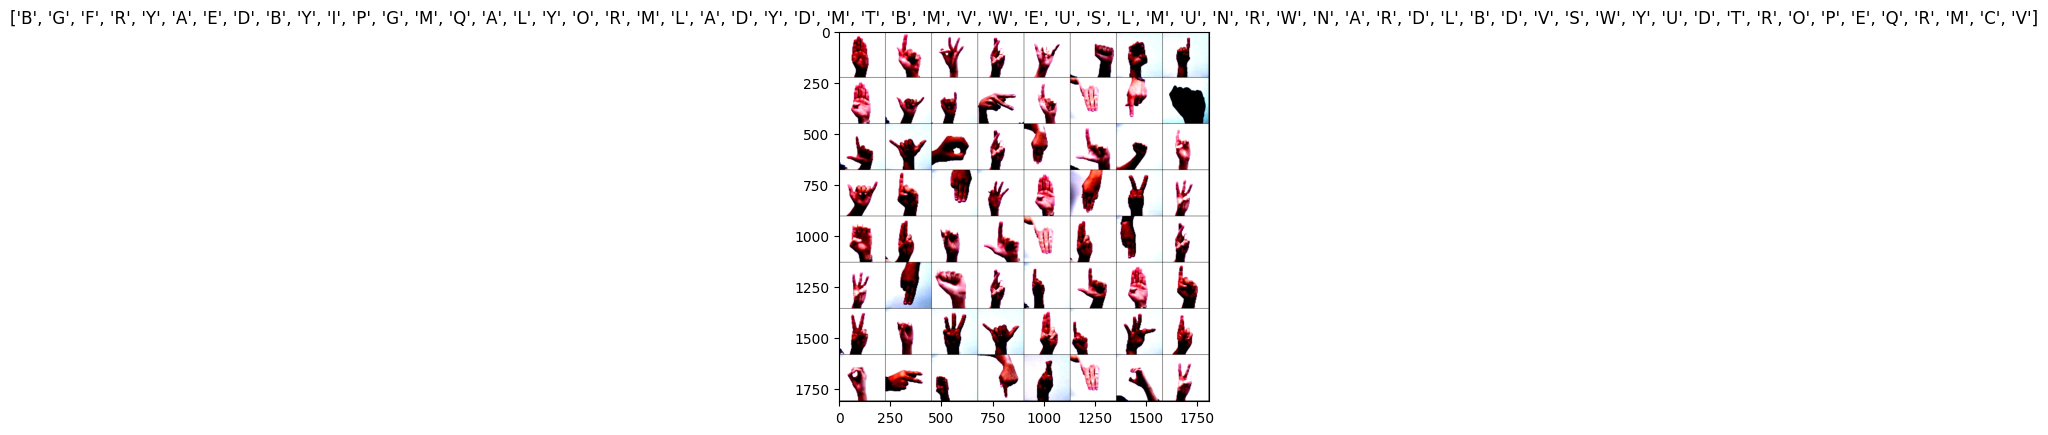

In [ ]:
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[label[x] for x in classes])

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    
    # Set model for evaluation
    model.train(False)
    model.eval() 
    
    images_so_far = 0
    
    if use_gpu:
        with torch.no_grad():
            model = model.to(device)

    for i, data in enumerate(dataloaders['test']):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            with torch.no_grad():
                inputs, labels = inputs.to(device), labels.to(device)
        else:
            with torch.no_grad():
                inputs, labels = inputs, labels
        
        outputs = model(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    model.train(mode=was_training)

Ground truth:


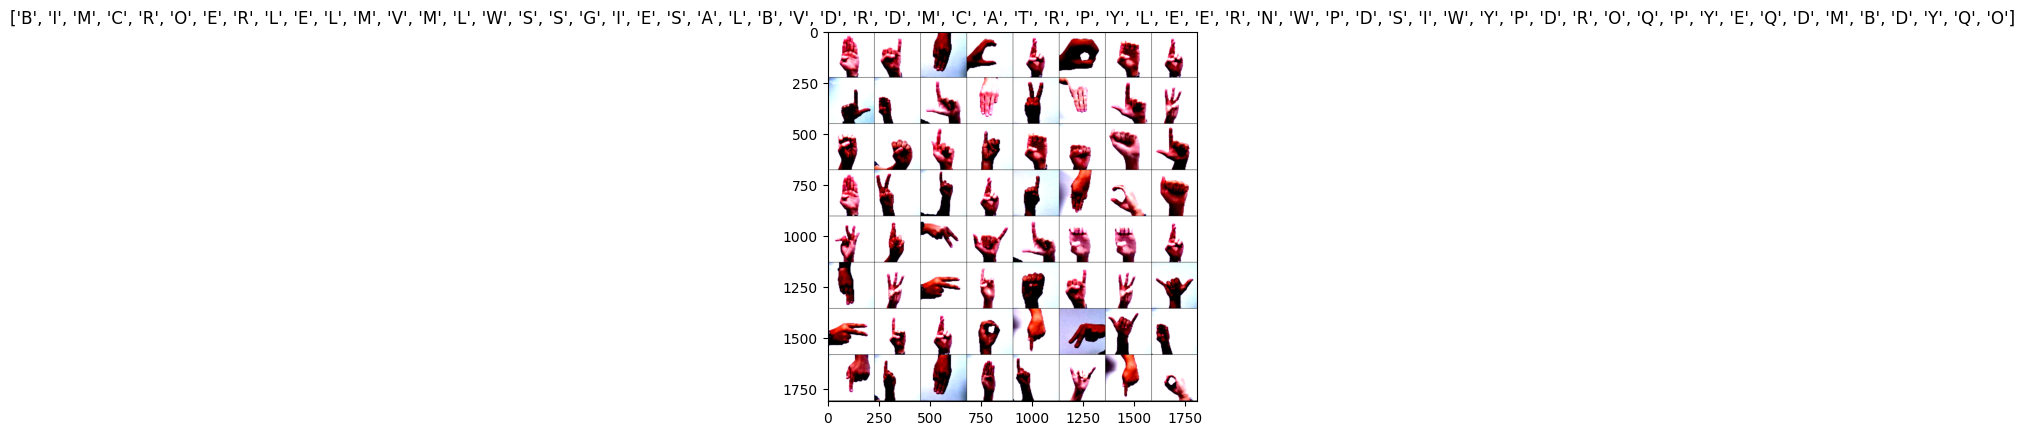

Prediction:


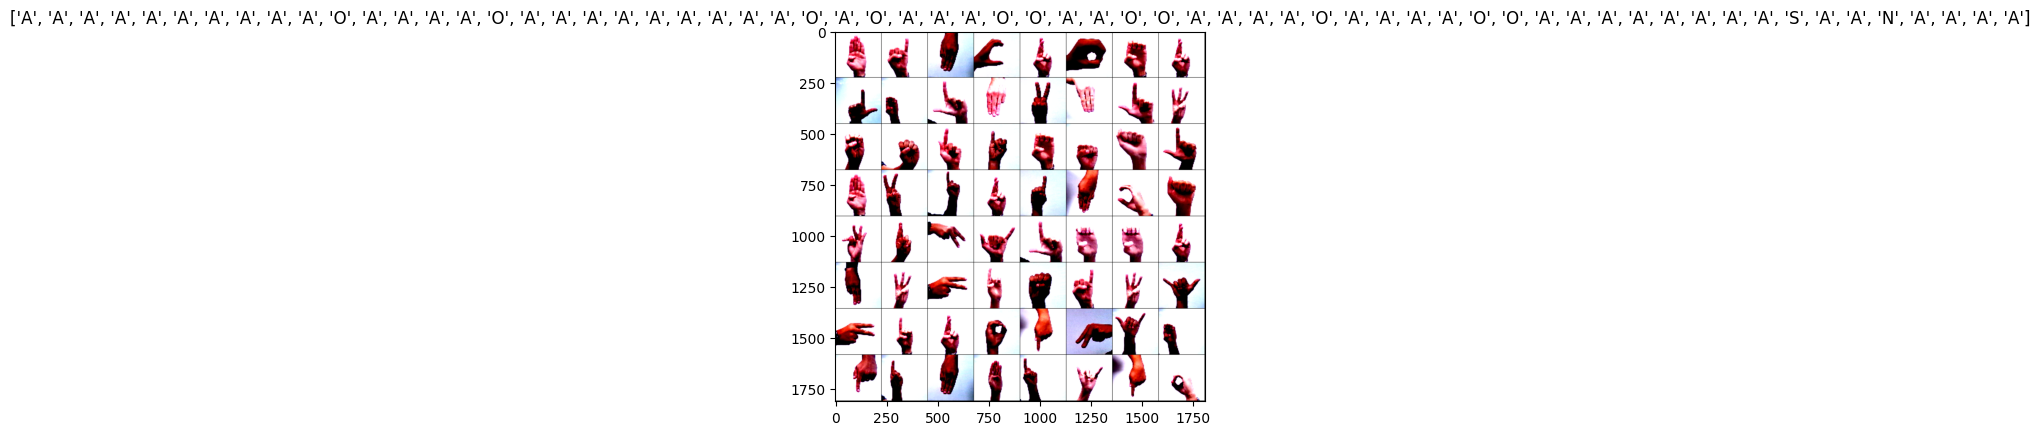

In [ ]:
torch.cuda.empty_cache()
visualize_model(model)

# Training

In [9]:
def train_model(model, criterion, optimizer, num_epochs=5):
    if use_gpu:
        with torch.no_grad():
            model = model.to(device)

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    
    train_batches = len(dataloaders['train'])
    
    loss_values = []
    acc_values = []
    for epoch in tqdm(range(num_epochs)):
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        
        model.train(True)
        pbar = tqdm(total=train_batches)
        for i, data in enumerate(dataloaders['train']):
            pbar.update(1)
                            
            inputs, labels= data
            
            if use_gpu:
                with torch.no_grad():
                    inputs, labels = inputs.cuda(), labels.cuda()
            else:
                with torch.no_grad():
                    inputs, labels = inputs, labels
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train  / dataset_sizes['train']
        avg_acc = acc_train  / dataset_sizes['train']
        loss_values.append(avg_loss)
        acc_values.append(avg_acc)
        model.train(False)
        model.eval()
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))

        print('-' * 10)
        print()
        
        if avg_acc > best_acc:
            best_acc = avg_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model,acc_values,loss_values

In [10]:
torch.cuda.empty_cache()
model,acc,loss = train_model(model, criterion, optimizer, num_epochs=num_epochs)
torch.save(model.state_dict(),'convnext_libras.pt')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0/4
----------


  0%|          | 0/543 [00:00<?, ?it/s]



Epoch 0 result: 
Avg loss (train): 0.0016
Avg acc (train): 0.9693
----------

Epoch 1/4
----------


  0%|          | 0/543 [00:00<?, ?it/s]



Epoch 1 result: 
Avg loss (train): 0.0008
Avg acc (train): 0.9861
----------

Epoch 2/4
----------


  0%|          | 0/543 [00:00<?, ?it/s]



Epoch 2 result: 
Avg loss (train): 0.0008
Avg acc (train): 0.9861
----------

Epoch 3/4
----------


  0%|          | 0/543 [00:00<?, ?it/s]



Epoch 3 result: 
Avg loss (train): 0.0008
Avg acc (train): 0.9859
----------

Epoch 4/4
----------


  0%|          | 0/543 [00:00<?, ?it/s]



Epoch 4 result: 
Avg loss (train): 0.0005
Avg acc (train): 0.9914
----------


Training completed in 94m 21s
Best acc: 0.9914


Text(0.5, 1.0, 'Convnext loss')

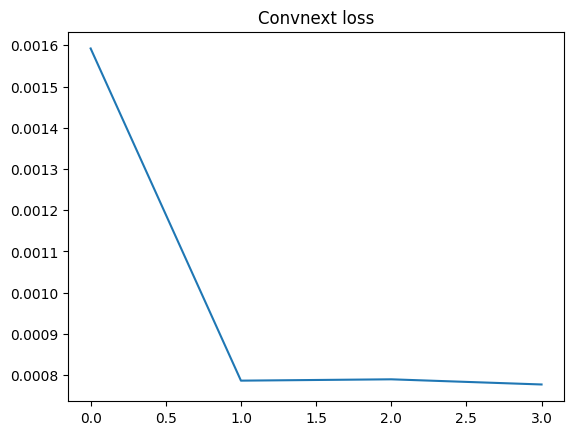

In [11]:
plt.plot([it for it in loss[:-1]])
plt.title("Convnext loss")

In [12]:
!ls

convnext_libras.pt  drive  sample_data


In [13]:
!cp  convnext_libras.pt drive/MyDrive/LIBRAS

cp: cannot create regular file 'drive/MyDrive/LIBRAS/convnext_libras.pt': Read-only file system


# Evaluating

In [8]:
PATH = "convnext_libras.pt"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [6]:
def eval_model(model, criterion):
    if use_gpu:
        with torch.no_grad():
            model = model.to(device)

    y_true = []
    y_pred = []
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders['test'])
    print("Evaluating model")
    print('-' * 10)
    pbar = tqdm(total=test_batches)
    for i, data in enumerate(dataloaders['test']):
        pbar.update(1)

        model.train(False)
        model.eval()
        
        inputs, labels = data
        
        y_true = y_true + labels.tolist()
        if use_gpu:
            with torch.no_grad():
                inputs, labels = inputs.cuda(), labels.cuda()
        else:
            with torch.no_grad():
                inputs, labels = inputs, labels
        
        outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        #print(preds)
        y_pred = y_pred + preds.tolist()
        
        loss_test += loss.item()
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes['test']
    avg_acc = acc_test / dataset_sizes['test']
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [9]:
criterion = nn.CrossEntropyLoss()
eval_model(model, criterion)

Evaluating model
----------


  0%|          | 0/181 [00:00<?, ?it/s]


Evaluation completed in 1m 24s
Avg loss (test): 0.0008
Avg acc (test): 0.9862
----------
